In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC

In [3]:
# Load preprocessed data
train_data = pd.read_csv('../Dataset/train_preprocessed.csv')
test_data = pd.read_csv('../Dataset/test_preprocessed.csv')

# Check the data
print(f"Training data shape: {train_data.shape}")
train_data.head()

Training data shape: (159571, 12)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,processed_text,original_length,processed_length,length_reduction
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation edits made username hardcore metal...,264,171,35.227273
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,daww match background colour im seemingly stuc...,112,71,36.607143
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man im really trying edit war guy constant...,233,144,38.197425
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,cant make real suggestion improvement wondered...,622,368,40.836013
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,sir hero chance remember page thats,67,35,47.761194


In [24]:
# Check for and handle missing values in the preprocessed text
print("Checking for missing values in preprocessed data...")
print(f"NaN values in processed_text: {X.isna().sum()}")

# Replace any NaN values with empty strings
X = X.fillna("")
print("Replaced NaN values with empty strings.")

# Check for missing values in target labels
print(f"Missing values in target labels:")
print(y.isna().sum())

# If there are missing values in the target, you can fill them with 0
if y.isna().sum().sum() > 0:
    y = y.fillna(0)
    print("Replaced missing target values with 0.")

Checking for missing values in preprocessed data...
NaN values in processed_text: 67
Replaced NaN values with empty strings.
Missing values in target labels:
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [25]:
# Define the features and target labels
X = train_data['processed_text']  # Use the preprocessed text
y = train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

# Handle missing values
X = X.fillna("")  # Replace NaN values with empty strings
y = y.fillna(0)   # Replace any missing target values with 0

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y['toxic']
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

Training set size: 127656
Validation set size: 31915


In [26]:
# Create a basic TF-IDF + Logistic Regression pipeline
tfidf = TfidfVectorizer(
    max_features=50000,  # Limit features to prevent overfitting
    min_df=2,            # Minimum document frequency
    max_df=0.8,          # Maximum document frequency
    ngram_range=(1, 2)   # Include unigrams and bigrams
)

# We'll use logistic regression as our base classifier
# For multi-label classification, we'll use MultiOutputClassifier
base_classifier = LogisticRegression(
    C=5.0,               # Regularization parameter
    solver='liblinear',  # Solver that works well with small/medium datasets
    max_iter=200,        # Increase max iterations to ensure convergence
    random_state=42
)

# Wrap the classifier with MultiOutputClassifier for multi-label classification
classifier = MultiOutputClassifier(base_classifier)

# Create a pipeline that first vectorizes the text, then applies the classifier
model = Pipeline([
    ('tfidf', tfidf),
    ('classifier', classifier)
])

# Train the model
print("Training the model...")
model.fit(X_train, y_train)
print("Model training complete!")

Training the model...
Model training complete!


In [27]:
# Evaluate the model on validation data
print("Evaluating model on validation data...")
y_pred = model.predict(X_val)

# Calculate accuracy and F1 score
print(f"Validation accuracy: {accuracy_score(y_val, y_pred):.4f}")

# Print F1 score for each label
print("\nF1 scores by toxicity type:")
for i, column in enumerate(y_val.columns):
    f1 = f1_score(y_val[column], y_pred[:, i])
    print(f"{column}: {f1:.4f}")

# Generate classification report for each label
for i, column in enumerate(y_val.columns):
    print(f"\nClassification report for {column}:")
    print(classification_report(y_val[column], y_pred[:, i]))

Evaluating model on validation data...
Validation accuracy: 0.9209

F1 scores by toxicity type:
toxic: 0.7670
severe_toxic: 0.3750
obscene: 0.7753
threat: 0.1818
insult: 0.6576
identity_hate: 0.3951

Classification report for toxic:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     28856
           1       0.89      0.67      0.77      3059

    accuracy                           0.96     31915
   macro avg       0.93      0.83      0.87     31915
weighted avg       0.96      0.96      0.96     31915


Classification report for severe_toxic:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     31604
           1       0.57      0.28      0.38       311

    accuracy                           0.99     31915
   macro avg       0.78      0.64      0.69     31915
weighted avg       0.99      0.99      0.99     31915


Classification report for obscene:
              precision    recall  f

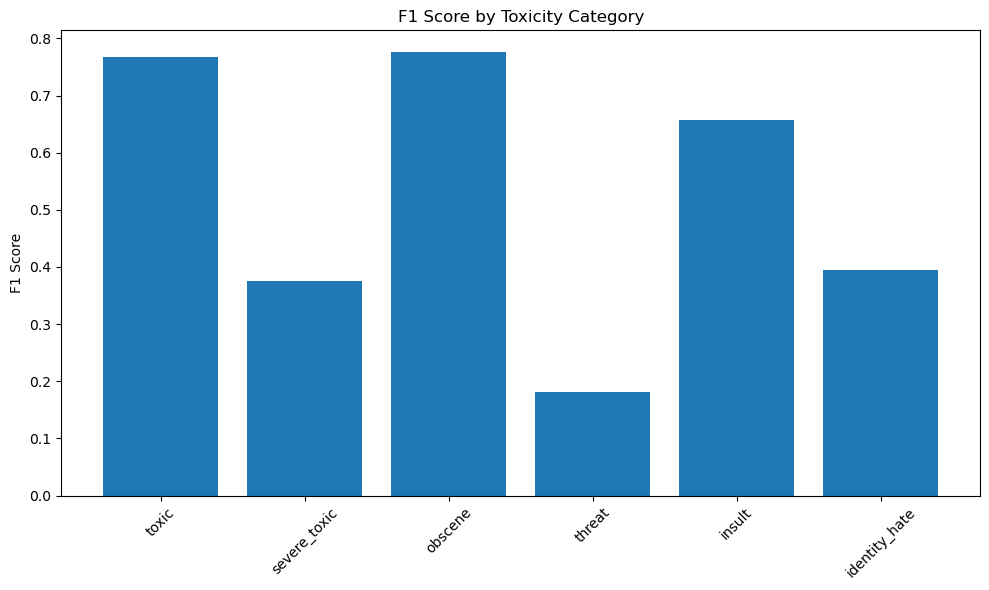

In [28]:
# Visualize the model performance
# Plot F1 scores by category
plt.figure(figsize=(10, 6))
f1_scores = [f1_score(y_val[col], y_pred[:, i]) for i, col in enumerate(y_val.columns)]
plt.bar(y_val.columns, f1_scores)
plt.title('F1 Score by Toxicity Category')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [34]:


# Create a TF-IDF + SVM pipeline
tfidf = TfidfVectorizer(
    max_features=20000,  # Reduced features for faster training
    min_df=2,            # Minimum document frequency
    max_df=0.8,          # Maximum document frequency
    ngram_range=(1, 2)   # Include unigrams and bigrams
)

# SVM as our base classifier
# LinearSVC is faster than SVC for text classification with large datasets
base_classifier = LinearSVC(
    C=1.0,               # Regularization parameter
    max_iter=10000,       # Increase max iterations to ensure convergence
    dual=False,          # 'dual=False' preferred when n_samples > n_features
    class_weight='balanced', # Handle class imbalance
    random_state=42
)

# Wrap the classifier with MultiOutputClassifier for multi-label classification
classifier = MultiOutputClassifier(base_classifier)

# Create a pipeline that first vectorizes the text, then applies the classifier
model = Pipeline([
    ('tfidf', tfidf),
    ('classifier', classifier)
])

# Train the model
print("Training the SVM model...")
model.fit(X_train, y_train)
print("SVM model training complete!")

Training the SVM model...
SVM model training complete!


In [38]:
# Evaluate the SVM model on validation data
print("Evaluating SVM model on validation data...")
y_pred = model.predict(X_val)

# Calculate accuracy and F1 score
print(f"Validation accuracy: {accuracy_score(y_val, y_pred):.4f}")

# Print F1 score for each label
print("\nF1 scores by toxicity type:")
for i, column in enumerate(y_val.columns):
    f1 = f1_score(y_val[column], y_pred[:, i])
    print(f"{column}: {f1:.4f}")

# Generate classification report for each label
for i, column in enumerate(y_val.columns):
    print(f"\nClassification report for {column}:")
    print(classification_report(y_val[column], y_pred[:, i]))

Evaluating SVM model on validation data...
Validation accuracy: 0.8702

F1 scores by toxicity type:
toxic: 0.7227
severe_toxic: 0.3979
obscene: 0.7387
threat: 0.3485
insult: 0.6343
identity_hate: 0.3644

Classification report for toxic:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97     28856
           1       0.64      0.84      0.72      3059

    accuracy                           0.94     31915
   macro avg       0.81      0.89      0.84     31915
weighted avg       0.95      0.94      0.94     31915


Classification report for severe_toxic:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     31604
           1       0.28      0.72      0.40       311

    accuracy                           0.98     31915
   macro avg       0.64      0.85      0.69     31915
weighted avg       0.99      0.98      0.98     31915


Classification report for obscene:
              precision    recal

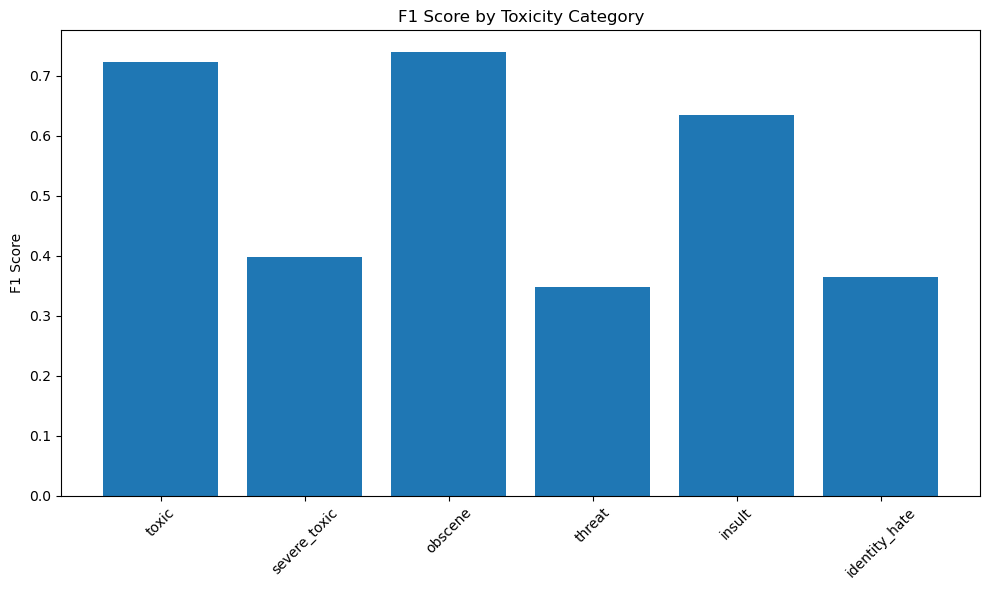

In [37]:
# Visualize the model performance
# Plot F1 scores by category
plt.figure(figsize=(10, 6))
f1_scores = [f1_score(y_val[col], y_pred[:, i]) for i, col in enumerate(y_val.columns)]
plt.bar(y_val.columns, f1_scores)
plt.title('F1 Score by Toxicity Category')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()